# EMNIST-GAN
so, I once answered a lecturer (Mr Percy Wong) to train a 5 year old how to recognize digits, I will use a GAN.

so let's use a GAN.

In this notebook, I will be making use of the EMNIST (Extended Modified NIST) dataset of handwritten digits AND alphabets to train a Generator and Discriminator. The use-case for this would be to solve captchas but primarily to settle that statement that I said about GANs a long time ago.

# ------ DANGER ZONE -------
## DO NOT RUN THE NEXT CELL IF YOU DON'T INTEND TO PIP INSTALL

In [1]:
!pip3 install extra_keras_datasets
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tensorflow
ERROR: No matching distribution found for tensorflow


In [2]:
import pandas as pd
import os
from extra_keras_datasets import emnist
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Activation, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.initializers import glorot_normal, RandomNormal, Zeros
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from tensorflow import keras
import numpy as np
from livelossplot import PlotLossesKeras
import random
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras import backend
import sys
from collections import Counter

Download the dataset byclass for EMNIST, change the dataset and labels here if you wish (there is EMNIST for japanese characters too!)

In [3]:
(x_train, y_train), (x_test, y_test) = emnist.load_data(type='byclass')

INFO:root:Loading dataset = emnist


## Dataset classes
These are the labels of our dataset, we'll use this to convert it from the result to the actual human-readable class

In [4]:
class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

## Load samples
Let's take some samples from our dataset and take a look at them.

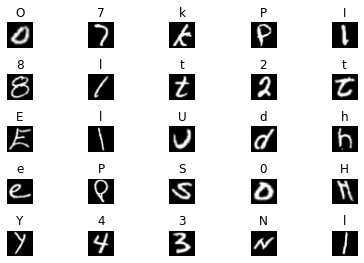

In [5]:
for i in range(25):
    # pick random image index from dataset to show
    index = random.randint(0, len(x_train))
    # define subplot
    plt.subplot(5, 5, 1 + i)
    plt.tight_layout()
    # turn off axis
    plt.axis('off')
    # change to grayscale as our images are in grayscale
    plt.imshow(x_train[index], cmap='gray')
    # show image title according to the real dataset classes
    plt.title(class_idx[y_train[index]])

## Reshape the data for training
Reshape x to 28,28,1 to include the colour channel and perform one hot encoding on y

In [6]:
# add an additional column for channels (our images are grayscale, so 1) and convert to float32
# expand to 3d, e.g. add channels
X = np.expand_dims(x_train, axis=-1).astype("float16")
# convert from ints to floats
X = X.astype('float16')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5
dataset = [X, y_train]

## Create the discriminator network
I will be using SimpleNet for its simplicity and high accuracy.
GANs take forever to train, every bit of performance is welcome. SimpleNet is also impressively accurate

model I built below is based off the pytorch model with LeakyReLU

SimpleNet paper : https://arxiv.org/abs/1608.06037

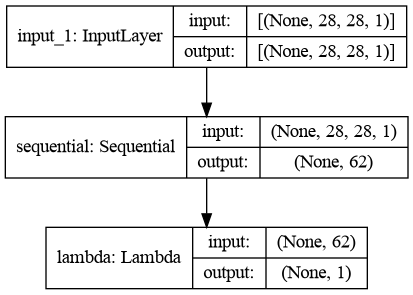

In [7]:
# custom activation function
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

model = Sequential()
# Block 1
model.add(Conv2D(64, (3,3), padding='same', kernel_initializer=glorot_normal()))
model.add(BatchNormalization())
model.add(LeakyReLU())

# Block 2,3,4 (repeated)
for i in range(3):
    model.add(Conv2D(128, (3,3), padding="same", kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# max pooling (change strides as you wish)
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.2))

# Block 5,6
for i in range (2):
    model.add(Conv2D(128, (3,3), padding="same", kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# Block 7
model.add(Conv2D(256, (3,3), padding="same", kernel_initializer=glorot_normal()))
model.add(BatchNormalization())
model.add(LeakyReLU())
# Another max pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.2))


# Block 8,9
for i in range(2):
    model.add(Conv2D(256, (3,3), padding="same", kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

# Block 10
model.add(Conv2D(512, (3,3), padding="same", kernel_initializer=glorot_normal()))
model.add(BatchNormalization())
model.add(LeakyReLU())

# Block 11
model.add(Conv2D(2048, (1,1), padding="same", kernel_initializer=glorot_normal()))
model.add(BatchNormalization())
model.add(LeakyReLU())

# Block 12
model.add(Conv2D(256, (1,1), padding="same", kernel_initializer=glorot_normal()))
model.add(BatchNormalization())
model.add(LeakyReLU())
# Another another another max pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.2))

# Block 13
model.add(Conv2D(256, (3,3), padding="same", kernel_initializer=glorot_normal()))
model.add(BatchNormalization())
model.add(LeakyReLU())
# Another another another max pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(len(class_idx)))
img = Input(shape=(28,28,1))
# Unsupervised output
features = model(img)
# use the custom activation function from the OpenAI paper
discriminator_out_layer = Lambda(custom_activation)(features)
discriminator_model = Model(img, discriminator_out_layer)
discriminator_model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002, beta_1=0.5))
# supervised output
categorical_out_layer = Activation("softmax")(features)
categorical_model = Model(img, categorical_out_layer)
categorical_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.0002, beta_1=0.5))

# plot both the classifier and discriminator models
plot_model(categorical_model, show_shapes=True, show_layer_names=True, to_file="simplenet-SGAN-categorical_model.png")
plot_model(discriminator_model, show_shapes=True, show_layer_names=True, to_file="simplenet-SGAN-discriminator_model.png")

## Define the generator model
This will be the GAN part of the equation. I will define a simple generator network as I don't really have much experience with more advanced networks like StyleGAN

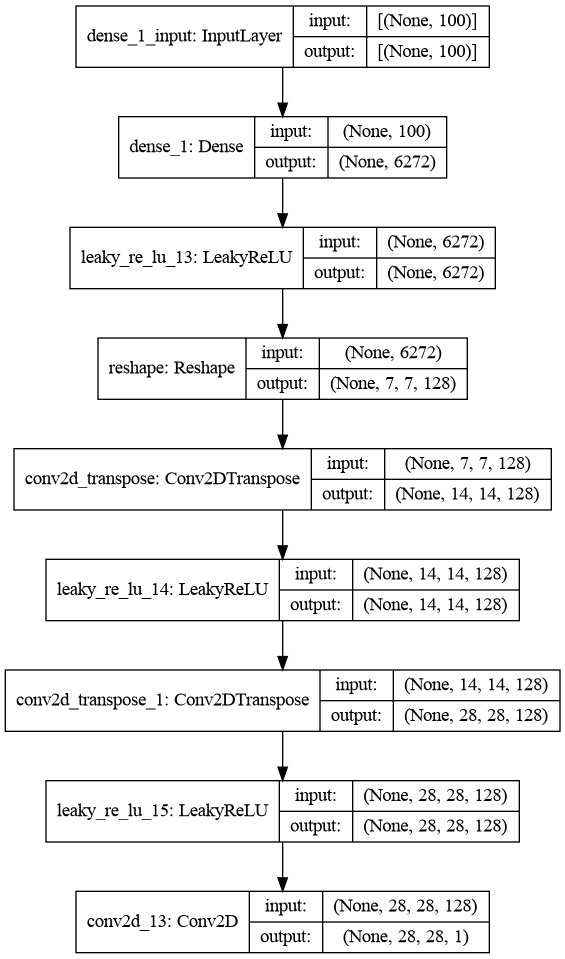

In [8]:
generator_model = Sequential()
generator_model.add(Dense(128*7*7, input_dim=100))
generator_model.add(LeakyReLU())
generator_model.add(Reshape((7,7,128)))
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
generator_model.add(LeakyReLU())
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
generator_model.add(LeakyReLU())
generator_model.add(Conv2D(1, (7,7), activation='tanh', padding="same"))
plot_model(generator_model, show_shapes=True, show_layer_names=True, to_file="generator-model.png")

## Define the Generative Adversarial Network
We need to connect the output of the generator with the discriminator, so they can train each other. Eventually the two networks will get good at:
1. Discriminating between a real and fake number
2. Generating data samples.
And this is the definition of a GAN.

In [9]:
# make the discriminator not trainable
discriminator_model.trainable = False
gan_output = discriminator_model(generator_model.output)
gan = Model(generator_model.input, gan_output)
# compile model
gan.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.002, beta_1=0.5))

## Define functions for getting real data samples
Yes, I just copy pasted the code in this section. Yes I understand what they're doing,
it's just that it is 3am and I am too lazy

In [10]:
# select a supervised subset of the dataset, ensures classes are balanced
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = np.random.randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return np.asarray(X_list), np.asarray(y_list)


# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return images, y

## Cool little function I stole from someone that saves the generator images when called

In [11]:
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		plt.subplot(10, 10, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

## Configure the image augmentation

In [12]:
# datagen = ImageDataGenerator(rotation_range=20)
# it = datagen.flow(x_train, y_train)

## Train the model


In [13]:
n_epochs = 100
n_batch = 32
latent_dim = 100
# use fp16 for very fast training
mixed_precision.set_global_policy('mixed_float16')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# select supervised dataset
X_sup, y_sup = select_supervised_samples(dataset)
print(X_sup.shape, y_sup.shape)
# calculate the number of batches per training epoch
bat_per_epo = int(dataset[0].shape[0] / n_batch)
# calculate the number of training iterations
n_steps = bat_per_epo * n_epochs
# calculate the size of half a batch of samples
half_batch = int(n_batch / 2)
print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
# manually enumerate epochs
for i in range(n_steps):
    # update supervised discriminator (c)
    [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
    c_loss = categorical_model.train_on_batch(Xsup_real, ysup_real)
    # update unsupervised discriminator (d)
    [X_real, _], y_real = generate_real_samples(dataset, half_batch)
    d_loss1 = discriminator_model.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
    d_loss2 = discriminator_model.train_on_batch(X_fake, y_fake)
    # update generator (g)
    X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
    g_loss = gan.train_on_batch(X_gan, y_gan)
    # summarize loss on this batch
    sys.stdout.write('\r'+f"iteration{i} categorical loss: {c_loss} discriminator real loss: {d_loss1} discriminator fake loss: {d_loss2} generator loss: {g_loss}")
    #print(, end="\r", flush=True)
    # evaluate the model performance every so often
    if (i+1) % (bat_per_epo * 1) == 0:
        summarize_performance(i, generator_model, categorical_model, latent_dim, dataset)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
Num GPUs Available:  1
(100, 28, 28, 1) (100,)
n_epochs=100, n_batch=32, 1/2=16, b/e=21810, steps=2181000
iteration21809 categorical loss: nan discriminator real loss: nan discriminator fake loss: nan generator loss: nans: nan generator loss: nanrator loss: nan2.33526420593261735105014749955

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6
/home/lucas/.conda/envs/py38/lib/python3.8/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/lucas/.conda/envs/py38/lib/python3.8/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/lucas/.conda/envs/py38/lib/python3.8/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/lucas/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element

TypeError: cannot unpack non-iterable float object

In [ ]:
from keras.models import load_model
score = discriminator_model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train'], loc='upper left')
# plt.show()

In [ ]:
categorical_model.save("aaaaav7.h5")
